<a href="https://colab.research.google.com/github/SzymonGogulski/OPENCV_PROJEKT_WDPO/blob/v2023/WDPO_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model klasyfikatora - projekt WDPO**

Opis
1.   Nadzorowana
2.   Klasyfikacja obrazów
3.   Wiele klas
4.   Pojedyńczy tag





### **Importuj paczki**

In [132]:
import tensorflow as tf
from tensorflow import keras as k
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imghdr
import shutil
from pathlib import Path

from google.colab.patches import cv2_imshow
from google.colab import drive

### **Połącz dysk google**

In [133]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Wgraj dataset**

In [153]:
dataset_filepath = Path('/content/gdrive/MyDrive/WDPO/liscie_dataset.zip')
target_directory_path = Path('/content')

!unzip -u {dataset_filepath} -d {target_directory_path}

Archive:  /content/gdrive/MyDrive/WDPO/liscie_dataset.zip


In [154]:
train_path = Path('/content/liscie_dataset/train')
test_path = Path('/content/liscie_dataset/test')

In [155]:
valid_ext = ['jpg', 'jpeg', 'png', 'bmp']

def remove_broken_files(data_dir):
  for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
      img_path = os.path.join(data_dir, img_class, img)
      try:
        image = cv2.imread(img_path)
        ext = imghdr.what(img_path)
        if ext not in valid_ext:
          print(f"Image with invalid extention{format(img_path)}")
          os.remove(img_path)
      except Exception as e:
        print(f"Faulty image{format(img_path)}")


remove_broken_files(train_path)
remove_broken_files(test_path)

### **Preprocessing obrazów**

In [148]:
batch_size = 4
image_size = (160, 160)
image_shape = (160, 160, 3)

(train_dataset, validate_dataset) = k.utils.image_dataset_from_directory(train_path,
                                                                         label_mode="categorical",
                                                                         validation_split=0.2,
                                                                         subset="both",
                                                                         seed=42,
                                                                         image_size=image_size,
                                                                         batch_size=batch_size)

test_dataset = k.utils.image_dataset_from_directory(test_path,
                                                    label_mode="categorical",
                                                    image_size=image_size,
                                                    batch_size=batch_size)

Found 200 files belonging to 5 classes.
Using 160 files for training.
Using 40 files for validation.
Found 77 files belonging to 5 classes.


In [138]:
data_iterator = test_dataset.as_numpy_iterator()
batch = data_iterator.next()

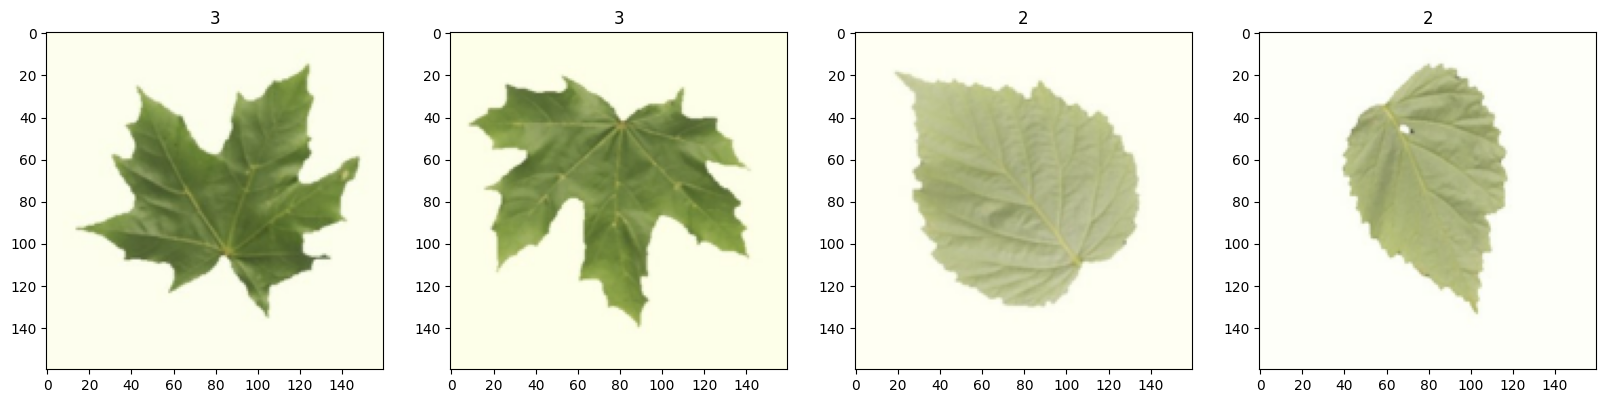

In [139]:
fig, ax = plt.subplots(ncols=batch_size, figsize=(20,20))
for idx, img in enumerate(batch[0]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### **MobileNet transfer learning**

In [140]:
MobileNet = k.applications.MobileNet(
    input_shape=image_shape,
    alpha=1.0,
    include_top=False,
    weights="imagenet"
)

MobileNet.trainable = False

In [ ]:
MobileNet.summary()

In [142]:
input = k.Input(shape=image_shape)
x = k.layers.Rescaling(1.0/255)(input)
x = MobileNet(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(256)(x)
output = k.layers.Dense(5, activation='softmax')(x)

model = k.Model(input, output)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### **Trening MobileNet**

In [143]:
checkpoint_callback = k.callbacks.ModelCheckpoint(
    filepath="model1",
    save_best_only=True,
    monitor="val_loss",
    save_format="tf")

In [145]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validate_dataset,
                    callbacks=[checkpoint_callback],
                    batch_size=batch_size)

Epoch 1/30
40/40 [==============================] - 22s 517ms/step - loss: 21.3199 - accuracy: 0.7937 - val_loss: 0.0375 - val_accuracy: 0.9750
Epoch 2/30
40/40 [==============================] - 8s 199ms/step - loss: 1.0986 - accuracy: 0.9812 - val_loss: 1.0701 - val_accuracy: 0.9750
Epoch 3/30
40/40 [==============================] - 19s 474ms/step - loss: 2.7645e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/30
40/40 [==============================] - 9s 216ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/30
40/40 [==============================] - 6s 156ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/30
40/40 [==============================] - 8s 200ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/30
40/40 [==============================] - 6s 154ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0016 - val_

### **Metryki modelu**

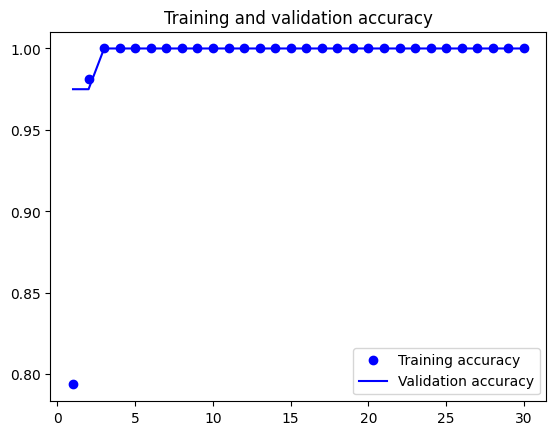

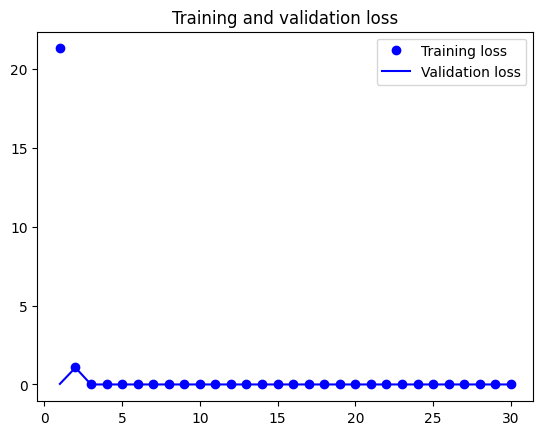

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [149]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

20/20 [==============================] - 2s 76ms/step - loss: 0.4670 - accuracy: 0.9610
Test accuracy: 0.961


### **Zapisz model do Google Drive**

In [151]:
!mkdir "/content/gdrive/MyDrive/WDPO/"
!mkdir "/content/gdrive/MyDrive/WDPO/model_tf"

In [152]:
!cp -r /content/model1/* /content/gdrive/MyDrive/WDPO/model_tf

### **Przykładowe predykcje**

In [158]:
example_filepath = Path('/content/gdrive/MyDrive/WDPO/example.zip')
target_directory_path = Path('/content')

!unzip -u {example_filepath} -d {target_directory_path}

Archive:  /content/gdrive/MyDrive/WDPO/example.zip
  inflating: /content/example/aspen.png  
  inflating: /content/example/birch.png  
  inflating: /content/example/hazel.png  
  inflating: /content/example/maple.png  
  inflating: /content/example/oak.png  


In [159]:
aspen_filepath = "/content/example/aspen.png"
birch_filepath = "/content/example/birch.png"
hazel_filepath = "/content/example/hazel.png"
maple_filepath = "/content/example/maple.png"
oak_filepath = "/content/example/oak.png"

aspen


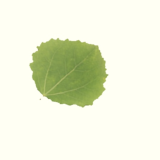

birch


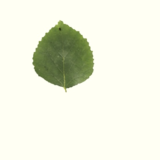

hazel


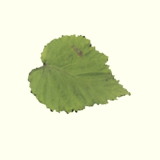

maple


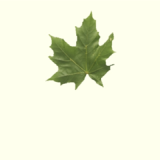

oak


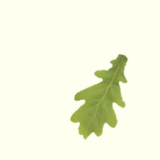

In [160]:
aspen_img = cv2.imread(aspen_filepath, cv2.IMREAD_COLOR)
aspen_resized = cv2.resize(aspen_img, image_size, interpolation = cv2.INTER_AREA)

birch_img = cv2.imread(birch_filepath, cv2.IMREAD_COLOR)
birch_resized = cv2.resize(birch_img, image_size, interpolation = cv2.INTER_AREA)

hazel_img = cv2.imread(hazel_filepath, cv2.IMREAD_COLOR)
hazel_resized = cv2.resize(hazel_img, image_size, interpolation = cv2.INTER_AREA)

maple_img = cv2.imread(maple_filepath, cv2.IMREAD_COLOR)
maple_resized = cv2.resize(maple_img, image_size, interpolation = cv2.INTER_AREA)

oak_img = cv2.imread(oak_filepath, cv2.IMREAD_COLOR)
oak_resized = cv2.resize(oak_img, image_size, interpolation = cv2.INTER_AREA)

print("aspen")
cv2_imshow(aspen_resized)

print("birch")
cv2_imshow(birch_resized)

print("hazel")
cv2_imshow(hazel_resized)

print("maple")
cv2_imshow(maple_resized)

print("oak")
cv2_imshow(oak_resized)

In [161]:
aspen_resized = np.expand_dims(aspen_resized, axis=0)
birch_resized = np.expand_dims(birch_resized, axis=0)
hazel_resized = np.expand_dims(hazel_resized, axis=0)
maple_resized = np.expand_dims(maple_resized, axis=0)
oak_resized = np.expand_dims(oak_resized, axis=0)

In [164]:
aspen_prediction = model.predict(aspen_resized)
birch_prediction = model.predict(birch_resized)
hazel_prediction = model.predict(hazel_resized)
maple_prediction = model.predict(maple_resized)
oak_prediction = model.predict(oak_resized)

1/1 [==============================] - 0s 75ms/step


In [166]:
print("Aspen: ", np.round(aspen_prediction, 3))
print("Birch: ", np.round(birch_prediction, 3))
print("Hazel: ", np.round(hazel_prediction, 3))
print("Maple: ", np.round(maple_prediction, 3))
print("Oak: ", np.round(oak_prediction, 3))


Aspen:  [[0. 1. 0. 0. 0.]]
Birch:  [[0. 1. 0. 0. 0.]]
Hazel:  [[0. 0. 1. 0. 0.]]
Maple:  [[0. 0. 0. 1. 0.]]
Oak:  [[0. 0. 0. 0. 1.]]
